In [236]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize

from pymongo import MongoClient
import collections
import matplotlib.pyplot as plt
import re
from random import choices
import string
nltk.download('popular', quiet = 'true')

True

In [237]:
#Mongo DB Information
client = MongoClient('localhost', 27017)
db = client['twitter']  
streaming_collection = db['streaming']
rest_collection = db['rest']
updated_geo = db['geo']

In [238]:
rest_rt = list(rest_collection.find({"retweeted_status":{"$exists": False}}))
streaming_rt = list(streaming_collection.find({"retweeted_status":{"$exists": False}}))
combined_list = rest_rt + streaming_rt
distinct_list = list({tweet['id']:tweet for tweet in combined_list}.values())
len(distinct_list)

1554

In [239]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [240]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer() ,
                             stop_words = "english", 
                             strip_accents = 'unicode',
                             lowercase = True,
                             min_df = 2)

In [241]:
corpus = []
translation = str.maketrans('','', string.punctuation)
for tweets in distinct_list:
    text = tweets['text']
    text = re.sub(r"http\S+", "", text) # remove links
    text = "".join(filter(lambda x: x in string.printable, text)) #remove non ascii
#     text = "".join([i for i in text if not i.isdigit()]) #remove digits
#     text = text.translate(translation) #remove puntuations
    text = re.sub(r'\b\w{1,3}\b', '', text) #remove characters less than 3
    corpus.append(text)
X = vectorizer.fit_transform(corpus)

In [242]:
Sum_of_squared_distances = []
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, n_jobs = -1).fit(X)
    Sum_of_squared_distances.append(kmeans.inertia_)

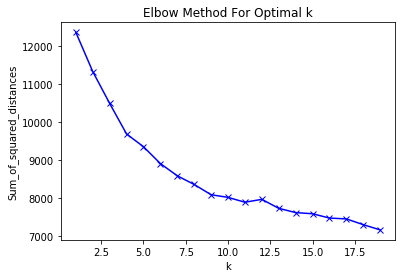

In [243]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [244]:
kmeans = KMeans(n_clusters=6, n_jobs = -1).fit(X)

In [245]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
collections.Counter(labels)

Counter({0: 1178, 4: 64, 5: 201, 1: 62, 3: 18, 2: 31})

In [252]:
list_size = len(collections.Counter(labels))
geo_tagged = [0] * list_size
profile_location = [0] * list_size
cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        geo_tagged[index] +=1
        key =  distinct_list[i]['place']['full_name']
        if key in cluster[index]:
            cluster[index][key] +=1
        else:
            cluster[index][key] = 1
    if distinct_list[i]['user']['location'] is not None:
        profile_location[index] +=1
geo_tagged

[161, 15, 0, 3, 15, 28]

In [247]:
def count_location_weights(cluster):
    location = []
    weights = []
    for i in range(list_size):
        for key in cluster[i]:
            counter = cluster[i][key]
            cluster[i][key] = counter/geo_tagged[i] * 100
            location.append(list(cluster[i].keys()))
            weights.append(list(cluster[i].values()))
    return location, weights

In [248]:
location, weights = count_location_weights(cluster)

In [249]:
#assigning geo based on probabilistic model
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is None:
        distinct_list[i]['assigned_geo'] = choices(location[index],weights[index])

In [254]:
list_size = len(collections.Counter(labels))
geo_counter = [0] * list_size
training_cluster = [dict() for x in range(list_size)]
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None:
        if int(geo_tagged[index]/2) != geo_counter[index]:
            geo_counter[index] += 1
            key =  distinct_list[i]['place']['full_name']
            distinct_list[i]["training"] = True
            if key in training_cluster[index]:
                training_cluster[index][key] +=1
            else:
                training_cluster[index][key] = 1
        else:
            distinct_list[i]["training"] = False

training_location, training_weights = count_location_weights(training_cluster) 

percentage = [0]* list_size 
for i in range(len(corpus)):
    index = labels[i]
    if distinct_list[i]['place'] is not None and distinct_list[i]["training"] is False:
        assigned = choices(training_location[index],training_weights[index])[0]
        if assigned == distinct_list[i]['place']['full_name']:
            percentage[index] += 1
            
for i in range(len(percentage)):
    if geo_tagged[i] == 0:
        print(f"No assignment possible due to no geo tweets in cluster {i}")
    else:
        print(f"Acuracy using 50% as training data and 50% as assignment for cluster {i}: {percentage[i]/(geo_tagged[i]/2) * 100}")

Acuracy using 50% as training data and 50% as assignment for cluster 0: 26.08695652173913
Acuracy using 50% as training data and 50% as assignment for cluster 1: 26.666666666666668
No assignment possible due to not geo tweets in cluster 2
Acuracy using 50% as training data and 50% as assignment for cluster 3: 66.66666666666666
Acuracy using 50% as training data and 50% as assignment for cluster 4: 53.333333333333336
Acuracy using 50% as training data and 50% as assignment for cluster 5: 28.57142857142857
